C:\Users\HP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



--- Expériences sur Boston Housing ---
Newton-CG (scipy) - LinearRegression MSE: 0.2877 (temps: 0.02s)

--- LinearRegression avec SGD (lr=0.01) ---
Epoch 0, Loss: 0.714126
Epoch 10, Loss: 0.261155
Epoch 20, Loss: 0.261535
Epoch 30, Loss: 0.259682
Epoch 40, Loss: 0.267907
Epoch 50, Loss: 0.259658
Epoch 60, Loss: 0.260299
Epoch 70, Loss: 0.260383
Epoch 80, Loss: 0.259222
Epoch 90, Loss: 0.263080
Temps total d'entraînement avec SGD : 2.18 secondes
Loss threshold 0.25 non atteint
Test MSE: 0.2950
Temps d'entraînement : 2.18 secondes
Seuil de loss 0.25 non atteint

--- LinearRegression avec SGD (lr=0.001) ---
Epoch 0, Loss: 0.826937
Epoch 10, Loss: 0.322605
Epoch 20, Loss: 0.279823
Epoch 30, Loss: 0.269654
Epoch 40, Loss: 0.264494
Epoch 50, Loss: 0.261855
Epoch 60, Loss: 0.260379
Epoch 70, Loss: 0.259197
Epoch 80, Loss: 0.258705
Epoch 90, Loss: 0.258286
Temps total d'entraînement avec SGD : 1.81 secondes
Loss threshold 0.25 non atteint
Test MSE: 0.2992
Temps d'entraînement : 1.81 secondes


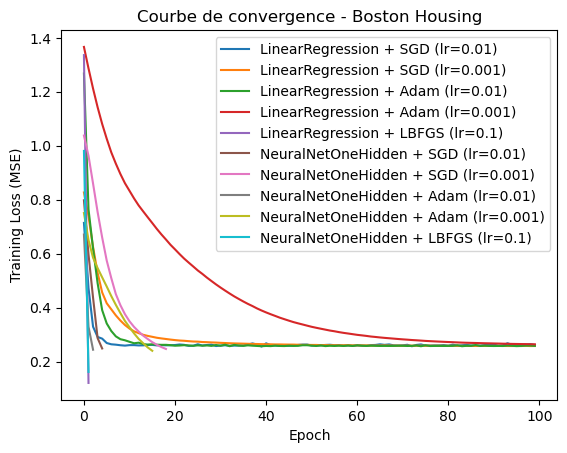


--- Expériences sur California Housing ---
Newton-CG (scipy) - LinearRegression MSE: 0.4175 (temps: 0.05s)

--- LinearRegression avec SGD (lr=0.01) ---
Epoch 0, Loss: 0.645759
Epoch 10, Loss: 1.074133
Epoch 20, Loss: 1.101470
Epoch 30, Loss: 0.943710
Epoch 40, Loss: 1.374605
Epoch 50, Loss: 1.335112
Epoch 60, Loss: 1.230789
Epoch 70, Loss: 0.989050
Epoch 80, Loss: 1.393917
Epoch 90, Loss: 1.195875
Temps total d'entraînement avec SGD : 75.88 secondes
Loss threshold 0.4 non atteint
Test MSE: 0.4057
Temps d'entraînement : 75.88 secondes
Seuil de loss 0.4 non atteint

--- LinearRegression avec SGD (lr=0.001) ---
Epoch 0, Loss: 0.727330
Epoch 10, Loss: 0.476922
Epoch 20, Loss: 0.666795
Epoch 30, Loss: 0.818240
Epoch 40, Loss: 0.932425
Epoch 50, Loss: 1.004973
Epoch 60, Loss: 1.069132
Epoch 70, Loss: 1.083065
Epoch 80, Loss: 1.112021
Epoch 90, Loss: 1.119201
Temps total d'entraînement avec SGD : 74.59 secondes
Loss threshold 0.4 non atteint
Test MSE: 0.4163
Temps d'entraînement : 74.59 seco

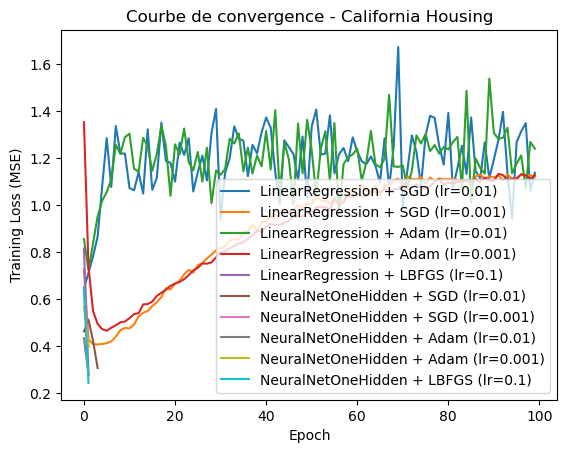

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml, fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

def prepare_boston():
    boston = fetch_openml(name='Boston', version=1, as_frame=True)
    df = boston.frame

    X = df.drop(columns=['MEDV']).copy()
    y = df['MEDV'].copy()

    num_cols = X.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, scaler_X, scaler_y

def prepare_california():
    california = fetch_california_housing(as_frame=True)
    df = california.frame

    X = df.drop(columns=['MedHouseVal']).copy()
    y = df['MedHouseVal'].copy()

    num_cols = X.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, scaler_X, scaler_y

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

class NeuralNetOneHidden(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.relu(self.hidden(x))
        return self.output(x)

def train_model(model, optimizer, criterion, train_loader, epochs=100, optimizer_name="", loss_threshold=None):
    model.train()
    losses = []
    start_time = time.time()

    epochs_to_threshold = None

    if optimizer_name == 'LBFGS':
        X_train_all, y_train_all = next(iter(train_loader))  # batch entier
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train_all)
            loss = criterion(outputs, y_train_all)
            loss.backward()
            return loss
        for epoch in range(epochs):
            loss = optimizer.step(closure)
            losses.append(loss.item())
            if loss_threshold is not None and loss.item() < loss_threshold:
                epochs_to_threshold = epoch + 1
                break
    else:
        for epoch in range(epochs):
            epoch_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            avg_loss = epoch_loss / len(train_loader.dataset)
            losses.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
            if loss_threshold is not None and avg_loss < loss_threshold:
                epochs_to_threshold = epoch + 1
                break

    end_time = time.time()
    duration = end_time - start_time
    print(f"Temps total d'entraînement avec {optimizer_name} : {duration:.2f} secondes")
    if epochs_to_threshold is not None:
        print(f"Nombre d'epochs pour atteindre loss < {loss_threshold} : {epochs_to_threshold}")
    else:
        print(f"Loss threshold {loss_threshold} non atteint")

    return losses, duration, epochs_to_threshold


def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        pred = model(X_tensor)
        mse = nn.functional.mse_loss(pred, y_tensor).item()
    return mse

def newton_cg_scipy(X_train, y_train, X_test, y_test):
    n_samples, n_features = X_train.shape
    X_train_ext = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_ext = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    def loss_func(w):
        pred = X_train_ext.dot(w)
        return np.mean((pred - y_train.flatten())**2)

    def grad_func(w):
        pred = X_train_ext.dot(w)
        return 2 * X_train_ext.T.dot(pred - y_train.flatten()) / n_samples

    w0 = np.zeros(n_features + 1)
    start = time.time()
    res = minimize(loss_func, w0, jac=grad_func, method='Newton-CG')
    duration = time.time() - start

    y_pred = X_test_ext.dot(res.x)
    mse = mean_squared_error(y_test, y_pred)
    return mse, duration

def run_all_experiments(X, y, scaler_y, dataset_name):
    print(f"\n--- Expériences sur {dataset_name} ---")

    # Seuil de perte en fonction du dataset
    if dataset_name == "Boston Housing":
        loss_threshold = 0.25
    elif dataset_name == "California Housing":
        loss_threshold = 0.4
    else:
        loss_threshold = 0.25

    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    input_dim = X_train.shape[1]

    models = {
        "LinearRegression": LinearRegressionModel(input_dim),
        "NeuralNetOneHidden": NeuralNetOneHidden(input_dim, hidden_dim=32)
    }

    learning_rates = {
        "SGD": [0.01, 0.001],
        "Adam": [0.01, 0.001],
        "LBFGS": [0.1]
    }

    criterion = nn.MSELoss()

    # Optimisation Newton-CG avec Scipy
    mse_newton, dur_newton = newton_cg_scipy(X_train, y_train, X_test, y_test)
    print(f"Newton-CG (scipy) - LinearRegression MSE: {mse_newton:.4f} (temps: {dur_newton:.2f}s)")

    for model_name, model in models.items():
        for opt_name in learning_rates.keys():
            for lr in learning_rates[opt_name]:
                print(f"\n--- {model_name} avec {opt_name} (lr={lr}) ---")

                model_copy = (
                    LinearRegressionModel(input_dim)
                    if model_name == "LinearRegression"
                    else NeuralNetOneHidden(input_dim, hidden_dim=32)
                )

                # Création de l'optimiseur avec learning rate dynamique
                if opt_name == "SGD":
                    optimizer = optim.SGD(model_copy.parameters(), lr=lr, momentum=0.9)
                elif opt_name == "Adam":
                    optimizer = optim.Adam(model_copy.parameters(), lr=lr)
                elif opt_name == "LBFGS":
                    optimizer = optim.LBFGS(model_copy.parameters(), lr=lr)

                losses, duration, epochs_to_thresh = train_model(
                    model_copy, optimizer, criterion, train_loader,
                    epochs=100, optimizer_name=opt_name, loss_threshold=loss_threshold
                )
                mse = evaluate_model(model_copy, X_test_tensor, y_test_tensor)

                print(f"Test MSE: {mse:.4f}")
                print(f"Temps d'entraînement : {duration:.2f} secondes")
                if epochs_to_thresh is not None:
                    print(f"Epochs pour atteindre loss < {loss_threshold} : {epochs_to_thresh}")
                else:
                    print(f"Seuil de loss {loss_threshold} non atteint")

                plt.plot(losses, label=f"{model_name} + {opt_name} (lr={lr})")

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss (MSE)')
    plt.title(f'Courbe de convergence - {dataset_name}')
    plt.legend()
    plt.show()



X_boston, y_boston, scaler_X_boston, scaler_y_boston = prepare_boston()
X_california, y_california, scaler_X_california, scaler_y_california = prepare_california()

run_all_experiments(X_boston, y_boston, scaler_y_boston, "Boston Housing")
run_all_experiments(X_california, y_california, scaler_y_california, "California Housing")
